   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.8637e+03                                    1.30e+04    
       1              2         5.5199e+03      2.34e+03       1.79e+01       7.71e+03    
       2              3         3.8549e+03      1.66e+03       3.09e+01       1.08e+03    
       3              4         3.8022e+03      5.27e+01       5.84e+00       5.44e+02    
       4              5         3.7884e+03      1.39e+01       3.11e+00       1.67e+02    
       5              6         3.7718e+03      1.66e+01       1.42e+00       3.23e+01    
       6              9         3.7716e+03      1.51e-01       2.97e-03       2.71e+01    
       7             10         3.7716e+03      3.65e-02       4.92e-02       9.24e+00    
       8             11         3.7716e+03      5.72e-03       4.69e-02       1.13e+00    
       9             12         3.7716e+03      3.31e-04       1.36e-02       1.03e-01    

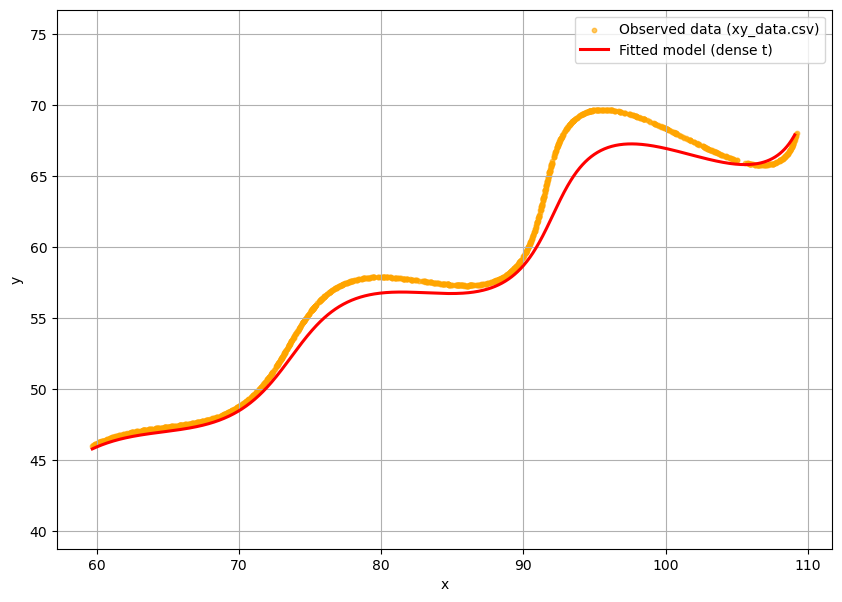

In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import math
import os

CSV_PATH = "xy_data.csv"
T_MIN, T_MAX = 6.0, 60.0
N_UNIFORM = 1000


THETA_BOUNDS_DEG = (1e-6, 50.0 - 1e-6)
M_BOUNDS = (-0.05 + 1e-8, 0.05 - 1e-8)
X_BOUNDS = (1e-8, 100.0 - 1e-8)

def load_xy(csv_path):
    df = pd.read_csv(csv_path)
    cols = [c.lower() for c in df.columns]
    if 't' in cols and 'x' in cols and 'y' in cols:
        t = df[df.columns[cols.index('t')]].values.astype(float)
        x = df[df.columns[cols.index('x')]].values.astype(float)
        y = df[df.columns[cols.index('y')]].values.astype(float)
        return x, y, t
    
    numeric_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
    if len(numeric_cols) < 2:
        raise ValueError("CSV must contain numeric x and y columns")
    x = df[numeric_cols[0]].values.astype(float)
    y = df[numeric_cols[1]].values.astype(float)
    t = np.linspace(T_MIN, T_MAX, len(x)) 
    return x, y, t

def model_xy(t, theta_deg, M, X):
    theta = np.deg2rad(theta_deg)
    expo = np.exp(M * np.abs(t))
    x = t * np.cos(theta) - expo * np.sin(0.3 * t) * np.sin(theta) + X
    y = 42.0 + t * np.sin(theta) + expo * np.sin(0.3 * t) * np.cos(theta)
    return x, y

def residuals(params, t, x_obs, y_obs):
    theta_deg, M, X = params
    x_m, y_m = model_xy(t, theta_deg, M, X)
    return np.concatenate([x_m - x_obs, y_m - y_obs])

def fit_params(x, y, t):
    p0 = np.array([10.0, 0.0, 10.0])
    lower = [THETA_BOUNDS_DEG[0], M_BOUNDS[0], X_BOUNDS[0]]
    upper = [THETA_BOUNDS_DEG[1], M_BOUNDS[1], X_BOUNDS[1]]
    res = least_squares(residuals, p0, args=(t, x, y), bounds=(lower, upper),
                        loss='huber', f_scale=0.1, xtol=1e-10, ftol=1e-10, verbose=2, max_nfev=5000)
    return res

def compute_L1(x_obs, y_obs, x_pred, y_pred):
    
    return np.sum(np.abs(x_obs - x_pred)) + np.sum(np.abs(y_obs - y_pred))

def main():
    if not os.path.exists(CSV_PATH):
        print(f"Place your '{CSV_PATH}' in this folder and run.")
        return
    x_obs, y_obs, t_obs = load_xy(CSV_PATH)
    res = fit_params(x_obs, y_obs, t_obs)
    theta_hat, M_hat, X_hat = res.x
    print("Estimated parameters:")
    print(f" theta (deg) = {theta_hat:.9f}")
    print(f" M = {M_hat:.12f}")
    print(f" X = {X_hat:.9f}")

   
    x_pred_obs, y_pred_obs = model_xy(t_obs, theta_hat, M_hat, X_hat)
    L1 = compute_L1(x_obs, y_obs, x_pred_obs, y_pred_obs)
    print(f"L1 distance (observed points) = {L1:.6f}")

   
    t_fit = np.linspace(T_MIN, T_MAX, N_UNIFORM)
    x_fit, y_fit = model_xy(t_fit, theta_hat, M_hat, X_hat)
    plt.figure(figsize=(10,7))
    plt.scatter(x_obs, y_obs, s=10, alpha=0.6, label="Observed data (xy_data.csv)", color='orange')
    plt.plot(x_fit, y_fit, 'r-', lw=2.2, label='Fitted model (dense t)')
    plt.axis('equal')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    os.makedirs("results", exist_ok=True)
    plot_path = os.path.join("results", "fitted_curve.png")
    plt.savefig(plot_path, dpi=200, bbox_inches='tight')
    print(f"Saved plot to {plot_path}")

    
    print("\nLaTeX-ready model (copy into README/Desmos):")
    print(rf"x(t) = \left(t\cos({theta_hat:.6f}^\circ) - e^{{{M_hat:.6f}|t|}}\sin(0.3t)\sin({theta_hat:.6f}^\circ) + {X_hat:.6f}\right)")
    print(rf"y(t) = \left(42 + t\sin({theta_hat:.6f}^\circ) + e^{{{M_hat:.6f}|t|}}\sin(0.3t)\cos({theta_hat:.6f}^\circ)\right)")

if __name__ == "__main__":
    main()


Fitting parameters


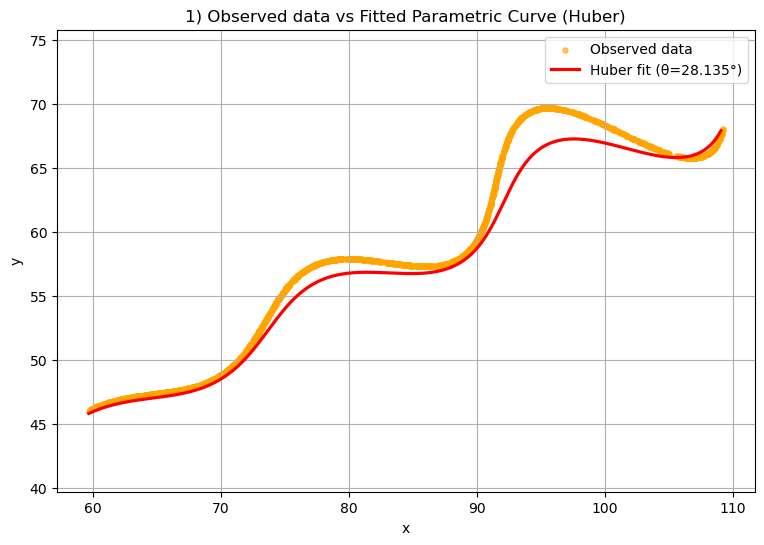

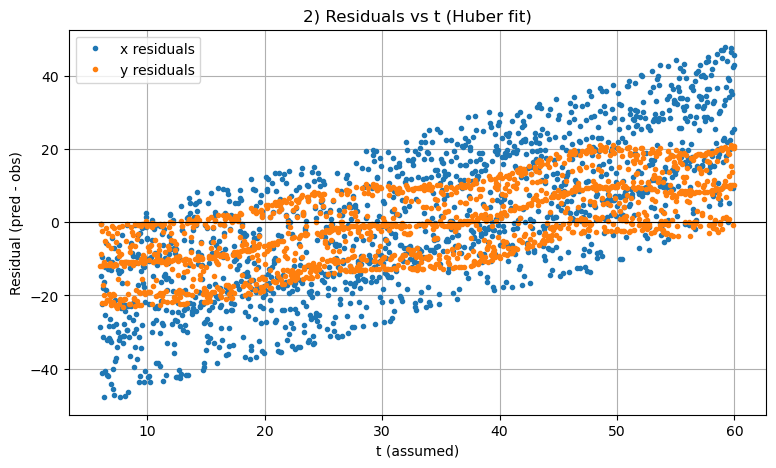

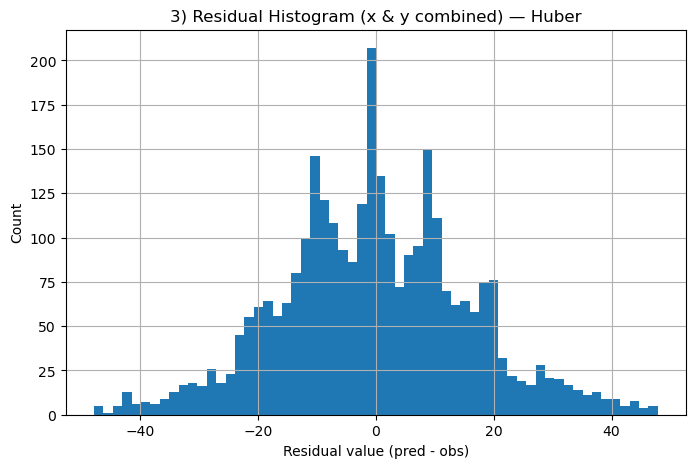

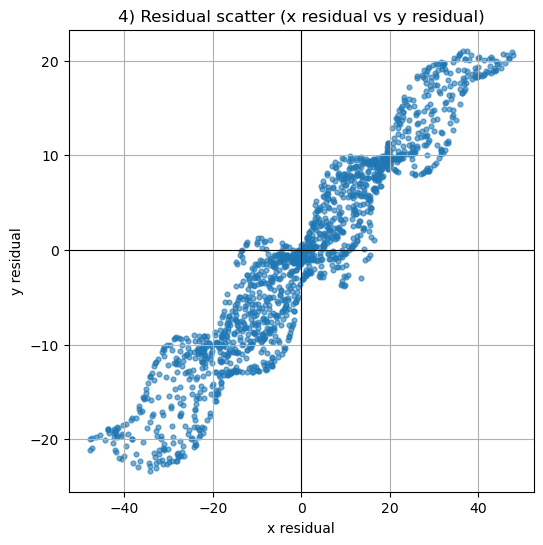

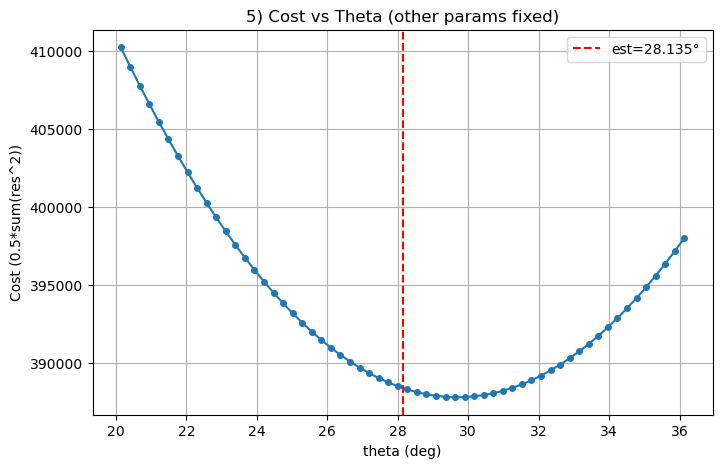

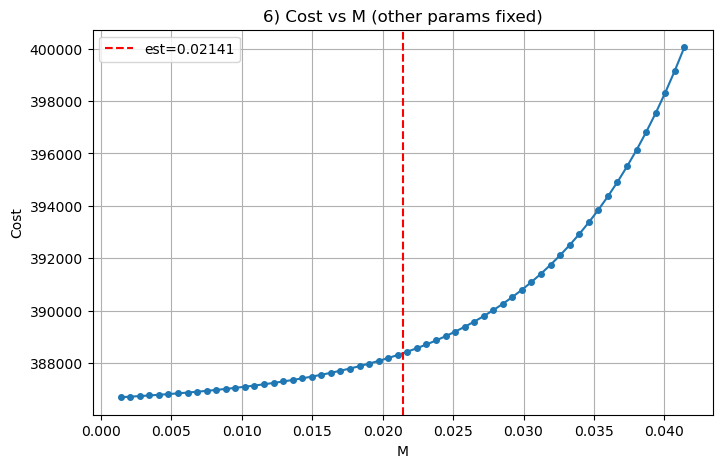

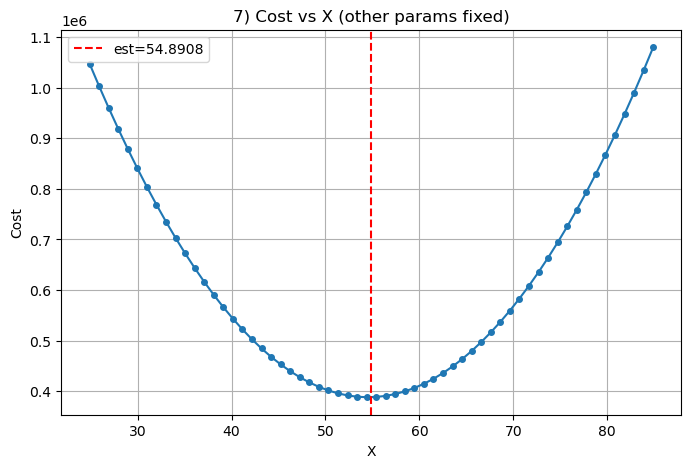

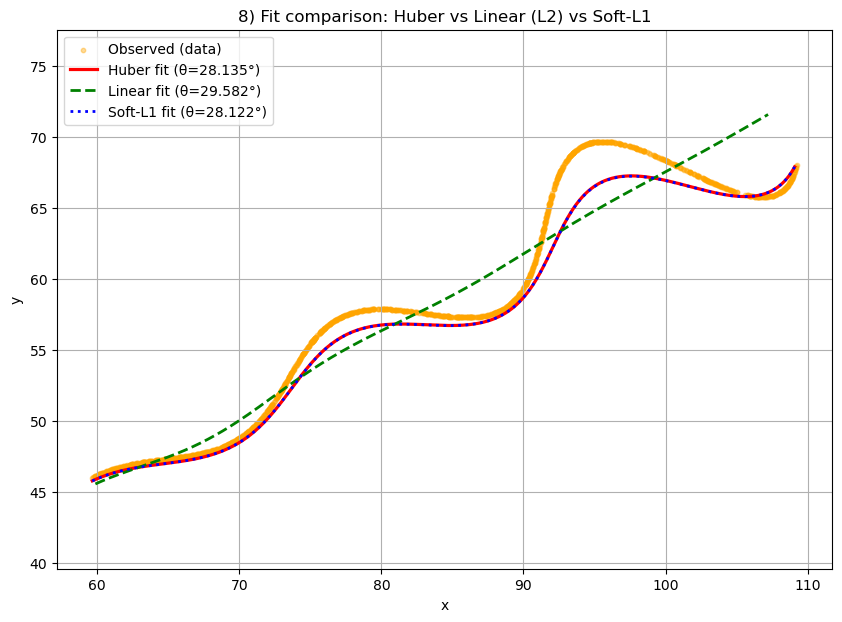

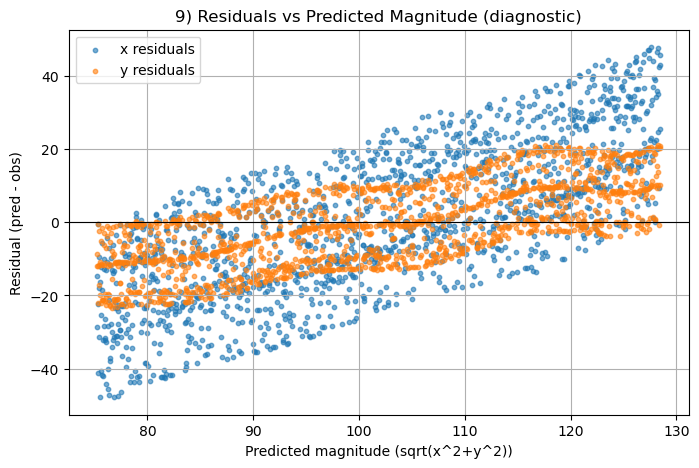


Huber fit (recommended):
 theta_deg = 28.135386142
 M = 0.021413213061
 X = 54.890830432
 L1 (observed t) = 37865.142172
 L2 (sqrt sum squares) = 881.335408

Parameter summary (all methods):
 method  theta_deg         M         X          cost
  huber  28.135386  0.021413 54.890830   3771.572454
 linear  29.581931 -0.050000 55.013359 385843.446340
soft_l1  28.121703  0.021336 54.884674   3757.116554

LaTeX-ready model (Huber estimates):
x(t) = \left(t\cos(28.135386^\circ) - e^{0.021413|t|}\sin(0.3t)\sin(28.135386^\circ) + 54.890830\right)
y(t) = \left(42 + t\sin(28.135386^\circ) + e^{0.021413|t|}\sin(0.3t)\cos(28.135386^\circ)\right)


In [7]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import math

CSV_PATH = "xy_data.csv"
RESULTS_DIR = "results"
SAVE_RESULTS = False
T_MIN, T_MAX = 6.0, 60.0
N_UNIFORM = 1000
THETA_BOUNDS_DEG = (1e-6, 50.0 - 1e-6)
M_BOUNDS = (-0.05 + 1e-8, 0.05 - 1e-8)
X_BOUNDS = (1e-8, 100.0 - 1e-8)

if SAVE_RESULTS:
    os.makedirs(RESULTS_DIR, exist_ok=True)

if not os.path.exists(CSV_PATH):
    print(f"ERROR: CSV file '{CSV_PATH}' not found in current folder: {os.getcwd()}")
    sys.exit(1)

df = pd.read_csv(CSV_PATH)
if 't' in df.columns:
    t_obs = df['t'].values.astype(float)
else:
    n = len(df)
    t_obs = np.linspace(T_MIN, T_MAX, n)
x_obs = df['x'].values.astype(float)
y_obs = df['y'].values.astype(float)

def model_xy(t, theta_deg, M, X):
    theta = np.deg2rad(theta_deg)
    expo = np.exp(M * np.abs(t))
    x = t * np.cos(theta) - expo * np.sin(0.3 * t) * np.sin(theta) + X
    y = 42.0 + t * np.sin(theta) + expo * np.sin(0.3 * t) * np.cos(theta)
    return x, y

def residuals(params, t, x_obs, y_obs):
    th, M, X = params
    x_m, y_m = model_xy(t, th, M, X)
    return np.concatenate([x_m - x_obs, y_m - y_obs])

p0 = np.array([10.0, 0.0, 10.0])
lower = [THETA_BOUNDS_DEG[0], M_BOUNDS[0], X_BOUNDS[0]]
upper = [THETA_BOUNDS_DEG[1], M_BOUNDS[1], X_BOUNDS[1]]
bounds = (lower, upper)

print("Fitting parameters")
res_huber = least_squares(residuals, p0, args=(t_obs, x_obs, y_obs),
                          bounds=bounds, loss='huber', f_scale=0.1, max_nfev=5000, verbose=0)
theta_h, M_h, X_h = res_huber.x

res_lin = least_squares(residuals, p0, args=(t_obs, x_obs, y_obs),
                        bounds=bounds, loss='linear', max_nfev=5000, verbose=0)
theta_l, M_l, X_l = res_lin.x

res_soft = least_squares(residuals, p0, args=(t_obs, x_obs, y_obs),
                         bounds=bounds, loss='soft_l1', f_scale=0.1, max_nfev=5000, verbose=0)
theta_s, M_s, X_s = res_soft.x

x_pred_h, y_pred_h = model_xy(t_obs, theta_h, M_h, X_h)
res_x = x_pred_h - x_obs
res_y = y_pred_h - y_obs
res_vec = np.concatenate([res_x, res_y])

L1_h = np.sum(np.abs(res_x)) + np.sum(np.abs(res_y))
L2_h = np.sqrt(np.sum(res_vec**2))

J = res_huber.jac
m, p = J.shape
cost = res_huber.cost
sigma2 = (2*cost) / max(m - p, 1)
cov = None
std_err = [np.nan]*p
try:
    cov = np.linalg.inv(J.T.dot(J)) * sigma2
    std_err = np.sqrt(np.diag(cov))
except Exception:
    cov = None

summary = pd.DataFrame({
    'method': ['huber', 'linear', 'soft_l1'],
    'theta_deg': [theta_h, theta_l, theta_s],
    'M': [M_h, M_l, M_s],
    'X': [X_h, X_l, X_s],
    'cost': [res_huber.cost, res_lin.cost, res_soft.cost]
})

if SAVE_RESULTS:
    summary.to_csv(os.path.join(RESULTS_DIR, "param_summary.csv"), index=False)
    with open(os.path.join(RESULTS_DIR, "fit_summary.txt"), "w") as f:
        f.write("Huber fit parameters (recommended):\n")
        f.write(f"theta_deg = {theta_h:.9f}\nM = {M_h:.12f}\nX = {X_h:.9f}\n\n")
        f.write(f"L1 (observed t) = {L1_h:.9f}\nL2 = {L2_h:.9f}\n\n")
        f.write("Approx std errors from Jacobian (if computed):\n")
        f.write(f"theta_std = {std_err[0]}\nM_std = {std_err[1]}\nX_std = {std_err[2]}\n\n")
        f.write("All method summaries:\n")
        f.write(summary.to_string(index=False))

t_fit_dense = np.linspace(T_MIN, T_MAX, N_UNIFORM)
x_fit_h, y_fit_h = model_xy(t_fit_dense, theta_h, M_h, X_h)
x_fit_l, y_fit_l = model_xy(t_fit_dense, theta_l, M_l, X_l)
x_fit_s, y_fit_s = model_xy(t_fit_dense, theta_s, M_s, X_s)

def show_and_maybe_save(fig, filename=None):
    if SAVE_RESULTS and filename:
        fig.savefig(os.path.join(RESULTS_DIR, filename), dpi=200, bbox_inches='tight')
        print(f"Saved: {os.path.join(RESULTS_DIR, filename)}")
    plt.show(block=True)

fig = plt.figure(figsize=(9,6))
plt.scatter(x_obs, y_obs, s=14, alpha=0.6, label="Observed data", color='orange')
plt.plot(x_fit_h, y_fit_h, 'r-', lw=2.3, label=f'Huber fit (θ={theta_h:.3f}°)')
plt.axis('equal')
plt.xlabel("x"); plt.ylabel("y")
plt.title("1) Observed data vs Fitted Parametric Curve (Huber)")
plt.legend(); plt.grid(True)
show_and_maybe_save(fig, "01_observed_vs_fitted.png")

fig = plt.figure(figsize=(9,5))
plt.plot(t_obs, res_x, '.', ms=6, label='x residuals')
plt.plot(t_obs, res_y, '.', ms=6, label='y residuals')
plt.axhline(0, color='k', lw=0.8)
plt.xlabel("t (assumed)"); plt.ylabel("Residual (pred - obs)")
plt.title("2) Residuals vs t (Huber fit)")
plt.legend(); plt.grid(True)
show_and_maybe_save(fig, "02_residuals_vs_t.png")

fig = plt.figure(figsize=(8,5))
plt.hist(res_vec, bins=60)
plt.xlabel("Residual value (pred - obs)"); plt.ylabel("Count")
plt.title("3) Residual Histogram (x & y combined) — Huber")
plt.grid(True)
show_and_maybe_save(fig, "03_residual_histogram.png")

fig = plt.figure(figsize=(6,6))
plt.scatter(res_x, res_y, s=12, alpha=0.6)
plt.axhline(0, color='k', lw=0.8); plt.axvline(0, color='k', lw=0.8)
plt.xlabel("x residual"); plt.ylabel("y residual")
plt.title("4) Residual scatter (x residual vs y residual)")
plt.grid(True)
show_and_maybe_save(fig, "04_residual_scatter.png")

thetas = np.linspace(max(THETA_BOUNDS_DEG[0], theta_h-8), min(THETA_BOUNDS_DEG[1], theta_h+8), 60)
costs_theta = []
for th in thetas:
    r = residuals([th, M_h, X_h], t_obs, x_obs, y_obs)
    costs_theta.append(0.5 * np.sum(r**2))
fig = plt.figure(figsize=(8,5))
plt.plot(thetas, costs_theta, '-o', ms=4)
plt.axvline(theta_h, color='r', linestyle='--', label=f'est={theta_h:.3f}°')
plt.xlabel("theta (deg)"); plt.ylabel("Cost (0.5*sum(res^2))")
plt.title("5) Cost vs Theta (other params fixed)")
plt.legend(); plt.grid(True)
show_and_maybe_save(fig, "05_cost_vs_theta.png")

Ms = np.linspace(max(M_BOUNDS[0], M_h-0.02), min(M_BOUNDS[1], M_h+0.02), 60)
costs_M = []
for Mval in Ms:
    r = residuals([theta_h, Mval, X_h], t_obs, x_obs, y_obs)
    costs_M.append(0.5 * np.sum(r**2))
fig = plt.figure(figsize=(8,5))
plt.plot(Ms, costs_M, '-o', ms=4)
plt.axvline(M_h, color='r', linestyle='--', label=f'est={M_h:.5f}')
plt.xlabel("M"); plt.ylabel("Cost")
plt.title("6) Cost vs M (other params fixed)")
plt.legend(); plt.grid(True)
show_and_maybe_save(fig, "06_cost_vs_M.png")

Xs = np.linspace(max(X_BOUNDS[0], X_h-30), min(X_BOUNDS[1], X_h+30), 60)
costs_X = []
for Xval in Xs:
    r = residuals([theta_h, M_h, Xval], t_obs, x_obs, y_obs)
    costs_X.append(0.5 * np.sum(r**2))
fig = plt.figure(figsize=(8,5))
plt.plot(Xs, costs_X, '-o', ms=4)
plt.axvline(X_h, color='r', linestyle='--', label=f'est={X_h:.4f}')
plt.xlabel("X"); plt.ylabel("Cost")
plt.title("7) Cost vs X (other params fixed)")
plt.legend(); plt.grid(True)
show_and_maybe_save(fig, "07_cost_vs_X.png")

fig = plt.figure(figsize=(10,7))
plt.scatter(x_obs, y_obs, s=10, alpha=0.4, label="Observed (data)", color='orange')
plt.plot(x_fit_h, y_fit_h, '-', lw=2.3, label=f'Huber fit (θ={theta_h:.3f}°)', color='red')
plt.plot(x_fit_l, y_fit_l, '--', lw=2.0, label=f'Linear fit (θ={theta_l:.3f}°)', color='green')
plt.plot(x_fit_s, y_fit_s, ':', lw=2.0, label=f'Soft-L1 fit (θ={theta_s:.3f}°)', color='blue')
plt.axis('equal'); plt.xlabel('x'); plt.ylabel('y')
plt.title("8) Fit comparison: Huber vs Linear (L2) vs Soft-L1")
plt.legend(); plt.grid(True)
show_and_maybe_save(fig, "08_fit_comparison.png")

pred_mags = np.sqrt(x_pred_h**2 + y_pred_h**2)
fig = plt.figure(figsize=(8,5))
plt.scatter(pred_mags, res_x, s=10, alpha=0.6, label='x residuals')
plt.scatter(pred_mags, res_y, s=10, alpha=0.6, label='y residuals')
plt.axhline(0, color='k', lw=0.8)
plt.xlabel("Predicted magnitude (sqrt(x^2+y^2))"); plt.ylabel("Residual (pred - obs)")
plt.title("9) Residuals vs Predicted Magnitude (diagnostic)")
plt.legend(); plt.grid(True)
show_and_maybe_save(fig, "09_residuals_vs_predicted_magnitude.png")

print("\nHuber fit (recommended):")
print(f" theta_deg = {theta_h:.9f}")
print(f" M = {M_h:.12f}")
print(f" X = {X_h:.9f}")
print(f" L1 (observed t) = {L1_h:.6f}")
print(f" L2 (sqrt sum squares) = {L2_h:.6f}")
print("\nParameter summary (all methods):")
print(summary.to_string(index=False))

print("\nLaTeX-ready model (Huber estimates):")
print(rf"x(t) = \left(t\cos({theta_h:.6f}^\circ) - e^{{{M_h:.6f}|t|}}\sin(0.3t)\sin({theta_h:.6f}^\circ) + {X_h:.6f}\right)")
print(rf"y(t) = \left(42 + t\sin({theta_h:.6f}^\circ) + e^{{{M_h:.6f}|t|}}\sin(0.3t)\cos({theta_h:.6f}^\circ)\right)")
